In [2]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 9.2 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
2025-05-26 01:32:41.034 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-26 01:32:41.083 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-05-26 01:32:41.083 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-26 01:32:41.086 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-26 01:32:41.087 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-26 01:32:41.089 Thread 'MainThread': missing ScriptRunContext! 

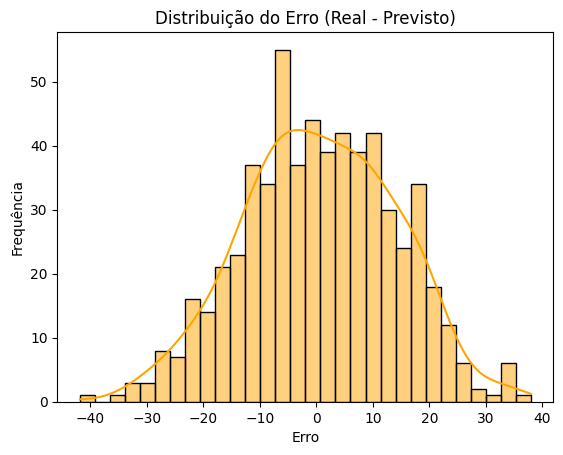

In [5]:
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import joblib
import nltk
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer

# Downloads NLTK
nltk.download('stopwords')
nltk.download('rslp')
stop_words = set(stopwords.words('portuguese'))
stemmer = RSLPStemmer()

# Preprocessamento reutilizável
def preprocess(text):
    text = re.sub(r'\W|\d', ' ', text.lower())
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

# Load the datasets
health_data = pd.read_csv('improved_health_data.csv')
traffic_data = pd.read_csv('improved_traffic_data.csv')
sentiment_data = pd.read_csv('improved_sentiment_data.csv')
recommendation_data = pd.read_csv('improved_recommendation_data.csv')
recommendation_data = recommendation_data[~recommendation_data['user'].isin(['User1', 'User2', 'User3', 'User4', 'User5'])]

# Sidebar for application selection
st.sidebar.title("Cidade Inteligente - Lumenópolis")
app_selection = st.sidebar.selectbox("Selecione a aplicação:", ["Previsão de Tráfego Urbano", "Classificação de Saúde Pública", "Análise de Sentimentos", "Sistema de Recomendação"])

# Previsão de Tráfego Urbano
if app_selection == "Previsão de Tráfego Urbano":
    st.title("🚦 Previsão de Tráfego Urbano")

    try:
        model_info = joblib.load("best_traffic_model_info.joblib")

        # Carregar y_test, y_pred e o array de erro PRÉ-CALCULADOS
        y_test = joblib.load("traffic_y_test.joblib")
        y_pred = joblib.load("traffic_y_pred.joblib")
        error = joblib.load("traffic_prediction_error.joblib")

        st.success("✅ Modelo, informações e resultados de teste carregados com sucesso.")
    except Exception as e:
        st.error(f"❌ Erro ao carregar os dados de teste pré-calculados ou o modelo: {e}")
        st.stop()

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Informações do modelo
    st.subheader("📘 Informações do Modelo")
    st.write(f"**Nome do Modelo:** {model_info.get('model_name', 'Desconhecido')}")
    st.write(f"**Métricas salvas:**")
    st.json(model_info.get("metrics", {}))

    st.subheader("📊 Avaliação da Previsão")
    st.write(f"**Erro Quadrático Médio (MSE):** {mse:.2f}")
    st.write(f"**Raiz do Erro Quadrático Médio (RMSE):** {rmse:.2f}")

    # Gráfico: Previsão vs Real e Distribuição do erro
    st.subheader("📈 Previsão vs Real")
    chart_data = pd.DataFrame({"Real": y_test.values, "Previsto": y_pred})
    st.line_chart(chart_data.head(100))

    st.subheader("📉 Distribuição dos Erros")
    fig, ax = plt.subplots()
    sns.histplot(error, bins=30, kde=True, ax=ax, color="orange")
    ax.set_title("Distribuição do Erro (Real - Previsto)")
    ax.set_xlabel("Erro")
    ax.set_ylabel("Frequência")
    st.pyplot(fig)

# Classificação de Saúde Pública
elif app_selection == "Classificação de Saúde Pública":
    st.title("Classificação de Saúde Pública")

    try:
        model = joblib.load("best_health_model.joblib")
        label_encoder = joblib.load("label_encoder_health.joblib")
        model_info = joblib.load("best_health_model_info.joblib")
        st.success("✅ Modelo carregado com sucesso.")
    except Exception as e:
        st.error(f"❌ Erro ao carregar o modelo: {e}")
        st.stop()

    # Mostrar nome e hiperparâmetros do modelo
    st.subheader("🔍 Modelo Selecionado")
    st.write(f"**Nome do Modelo:** {model_info['model_name']}")
    st.write("**Melhores Hiperparâmetros:**")
    st.json(model_info["best_params"])

    # Carregar e preparar os dados
    data = pd.read_csv("improved_health_data.csv")
    data['risk_level'] = data['risk_level'].str.lower()
    data['risk_level'] = label_encoder.transform(data['risk_level'])

    X = data.drop('risk_level', axis=1)
    y = data['risk_level']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    y_pred = model.predict(X_scaled)

    acc = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred, target_names=label_encoder.classes_, output_dict=True)
    cm = confusion_matrix(y, y_pred)

    st.write(f"📈 **Acurácia Geral:** `{acc:.2f}`")

    st.subheader("📊 Relatório de Classificação")
    st.dataframe(pd.DataFrame(report).transpose().round(2))

    # Matriz de confusão
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                ax=ax)
    ax.set_title("🔷 Matriz de Confusão")
    ax.set_xlabel("Previsto")
    ax.set_ylabel("Real")
    st.pyplot(fig)

    # Gráfico: Precisão por Classe
    st.subheader("🎯 Precisão por Classe")
    precision_by_class = [report[cls]['precision'] for cls in label_encoder.classes_]
    fig2, ax2 = plt.subplots()
    sns.barplot(x=label_encoder.classes_, y=precision_by_class, palette="viridis", ax=ax2)
    ax2.set_title("Precisão por Classe")
    ax2.set_ylabel("Precisão")
    ax2.set_ylim(0, 1)
    st.pyplot(fig2)

    # Gráfico: Distribuição real vs previsto
    st.subheader("📊 Distribuição: Real vs Previsto")
    df_compare = pd.DataFrame({
        "Real": label_encoder.inverse_transform(y),
        "Previsto": label_encoder.inverse_transform(y_pred)
    })
    fig3, ax3 = plt.subplots(figsize=(8, 4))
    sns.countplot(data=pd.melt(df_compare), x="value", hue="variable", palette="Set2", ax=ax3)
    ax3.set_title("Distribuição dos Rótulos: Real vs Previsto")
    ax3.set_xlabel("Nível de Risco")
    ax3.set_ylabel("Contagem")
    st.pyplot(fig3)

# Análise de Sentimentos
elif app_selection == "Análise de Sentimentos":
    st.title("🧠 Análise de Sentimentos da População")

    st.subheader("🔍 Previsão com Modelo Treinado (TF-IDF + SMOTE + Classificador)")

    # Carregar modelo e encoder
    try:
        pipeline = joblib.load('sentiment_model.joblib')
        label_encoder = joblib.load('label_encoder.joblib')
        st.success("✅ Modelo carregado com sucesso.")
    except Exception as e:
        st.error(f"❌ Erro ao carregar o modelo: {e}")
        st.stop()

    # Pré-processar os textos
    sentiment_data['text_clean'] = sentiment_data['text'].apply(preprocess)
    sentiment_data = sentiment_data.dropna(subset=['text_clean'])

    X = sentiment_data['text_clean']
    y = label_encoder.transform(sentiment_data['sentiment'])

    # Prever com o modelo
    y_pred = pipeline.predict(X)

    # Exibir métricas
    st.subheader("📊 Resultados do Modelo")

    acc = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred, target_names=label_encoder.classes_, output_dict=True)
    report_text = classification_report(y, y_pred, target_names=label_encoder.classes_)

    st.markdown(f"**Acurácia geral:** `{acc:.2f}`")
    st.text("Relatório de Classificação:")
    st.text(report_text)

    # Matriz de confusão
    st.subheader("🧩 Matriz de Confusão")
    cm = confusion_matrix(y, y_pred)
    fig1, ax1 = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=ax1)
    ax1.set_title("Matriz de Confusão")
    ax1.set_xlabel("Previsto")
    ax1.set_ylabel("Real")
    st.pyplot(fig1)

    # Gráfico de métricas por classe
    st.subheader("📈 Métricas por Classe")
    metrics_df = pd.DataFrame(report).transpose().iloc[:-3][['precision', 'recall', 'f1-score']]
    fig2, ax2 = plt.subplots()
    metrics_df.plot(kind='bar', ax=ax2)
    ax2.set_title("Precisão, Revocação e F1-Score por Classe")
    ax2.set_ylim(0, 1.05)
    st.pyplot(fig2)

    # Palavras mais comuns por classe
    st.subheader("🗣️ Palavras Mais Frequentes por Sentimento")
    selected_label = st.selectbox("Escolha o sentimento:", label_encoder.classes_)

    most_common_words = (
        ' '.join(sentiment_data[sentiment_data['sentiment'] == selected_label]['text_clean'])
        .split()
    )
    most_common_df = pd.Series(most_common_words).value_counts().head(10)

    fig4, ax4 = plt.subplots()
    sns.barplot(x=most_common_df.values, y=most_common_df.index, palette='crest', ax=ax4)
    ax4.set_title(f"Palavras mais comuns em: {selected_label}")
    ax4.set_xlabel("Frequência")
    ax4.set_ylabel("Palavra")
    st.pyplot(fig4)

    # Parâmetros do modelo
    st.subheader("⚙️ Parâmetros e Configurações do Modelo")
    try:
        model_config = pipeline.get_params()
        vectorizer = pipeline.named_steps['tfidf']
        classifier = pipeline.named_steps['clf']

        st.markdown("**Vetorizador TF-IDF:**")
        st.json({
            "ngram_range": vectorizer.ngram_range,
            "max_df": vectorizer.max_df,
            "min_df": vectorizer.min_df,
            "sublinear_tf": vectorizer.sublinear_tf
        })

        st.markdown("**Classificador:**")
        st.text(str(classifier))
    except:
        st.warning("Não foi possível exibir os parâmetros detalhados do modelo.")

# Sistema de Recomendação
elif app_selection == "Sistema de Recomendação":
    st.title("Sistema de Recomendações de Serviços Públicos")

    # Entrada de novo usuário
    st.subheader("📌 Cadastrar novo usuário e suas avaliações")
    new_user = st.text_input("ID do novo usuário (ex: NovoUser1):")
    all_services = recommendation_data['service'].unique()

    selected_services = st.multiselect("Selecione os serviços utilizados:", all_services)
    new_ratings = {}
    for service in selected_services:
        rating = st.slider(f"Avaliação para o serviço '{service}'", 1, 5, 3)
        new_ratings[service] = rating

    if st.button("Adicionar usuário"):
        for service, rating in new_ratings.items():
            new_entry = {
                'user': new_user,
                'service': service,
                'rating': rating,
                'frequency': 1  # Pode ajustar ou pedir input também
            }
            recommendation_data = pd.concat([recommendation_data, pd.DataFrame([new_entry])], ignore_index=True)
        st.success(f"Usuário {new_user} adicionado com sucesso!")
        all_users = recommendation_data['user'].unique()
    else:
        all_users = recommendation_data['user'].unique()

    # Construir matriz atualizada
    recommendation_data['weighted_interest'] = recommendation_data['rating'] * recommendation_data['frequency']
    user_service_matrix = recommendation_data.pivot_table(index='user', columns='service', values='weighted_interest', aggfunc='mean', fill_value=0)
    user_service_matrix_normalized = user_service_matrix.div(user_service_matrix.sum(axis=1), axis=0)

    user_similarity = cosine_similarity(user_service_matrix)
    user_similarity_df = pd.DataFrame(user_similarity, index=user_service_matrix.index, columns=user_service_matrix.index)

    user_similarity_normalized = cosine_similarity(user_service_matrix_normalized)
    user_similarity_normalized_df = pd.DataFrame(user_similarity_normalized, index=user_service_matrix_normalized.index, columns=user_service_matrix_normalized.index)

    # Função atualizada com fallback
    def recommend_services(user, matrix, similarity_df, top_n=5):
        if user not in matrix.index:
            st.warning(f"Usuário '{user}' não encontrado.")
            return pd.Series(dtype='float64')

        similarity_scores = similarity_df[user]
        similar_users = similarity_scores.nlargest(top_n + 1).index[1:]
        weighted_scores = sum(similarity_df[user][sim_user] * matrix.loc[sim_user] for sim_user in similar_users)
        user_services = matrix.loc[user]
        not_rated = user_services[user_services.isnull() | (user_services == 0)].index

        if len(not_rated) == 0:
            st.info(f"Usuário '{user}' já utilizou todos os serviços. Recomendando os mais populares.")
            return matrix.sum().sort_values(ascending=False).head(top_n)

        recommendations = weighted_scores.loc[not_rated].nlargest(top_n)

        if recommendations.empty:
            st.info(f"Nenhuma recomendação personalizada. Recomendando os mais populares.")
            return matrix.sum().sort_values(ascending=False).head(top_n)

        return recommendations

    # Interface de recomendação
    st.subheader("🔍 Obter recomendações")
    selected_user = st.selectbox("Selecione o usuário para recomendação:", all_users)

    if st.button("Recomendar serviços"):
        recs = recommend_services(selected_user, user_service_matrix, user_similarity_df, top_n=5)
        st.write(f"📢 Recomendações para {selected_user}:")
        st.write(recs)

    # Visualizações
    st.subheader("🎯 Mapa de Calor da Similaridade entre Usuários")
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(user_similarity_df, annot=True, cmap="coolwarm", square=True, ax=ax)
    ax.set_title("Similaridade entre Usuários")
    st.pyplot(fig)

    st.subheader("📊 Popularidade dos Serviços")
    service_counts = user_service_matrix.sum().sort_values(ascending=False)
    fig2, ax2 = plt.subplots()
    sns.barplot(x=service_counts.index, y=service_counts.values, color='skyblue', ax=ax2)
    ax2.set_title("Serviços Mais Utilizados")
    ax2.set_xlabel("Serviço")
    ax2.set_ylabel("Pontuação Total")
    st.pyplot(fig2)

In [7]:
!streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.106.147.70:8501

  Stopping...
  Stopping...
